# Sarcasm Detection on Reddit Comment using LSTM

### 1- Preliminaries

In [ ]:
# numpy module for numeric data processing and vectorization
import numpy as np

# pandas module for opening dataset & processing it
import pandas as pd

# for text cleaning purposes
import re

# to fix random seeds 
import os
import random

# for making progress bar
from tqdm.notebook import tqdm

# for making plots
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# for making word cloud
from wordcloud import WordCloud, STOPWORDS

# evaluation metrics 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# keras for deep learning model creation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.utils import plot_model

# other modules
import tensorflow as tf
import torch

### 2- Reading the dataset 
Pandas is the best when it comes to read a CSV file!

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train-balanced-sarcasm.csv")
print(df.shape)
df.head(n=3)

(1010826, 10)


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.


What we need to perform sarcasm detection on this dataset is `comment` & `label` column.<br>
We can drop the other features as they're not necessary for this task.

In [ ]:
# removing unnecessary columns from the dataframe using the drop method
# axis = 1 to delete by column name and inplae = True for not to return the applied method
df.drop(['author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'], axis=1, inplace=True)
# removing empty rows from the data frame
df.dropna(inplace=True)

# train_df.dropna(subset=['comment'], inplace=True)
df.head(n=3)

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."


### 3- EDA 
Applying some exploratory data analysis on the data to have a better sense of the dataset

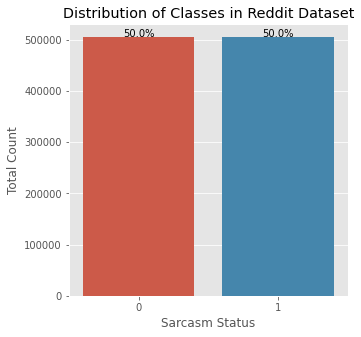

In [ ]:
# Plotting the distribution of classes in the dataset
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= df)
ax.set(title = "Distribution of Classes in Reddit Dataset", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format((height/total)*100),
            ha="center") 
plt.show()

In [ ]:
df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

The good news is that the dataset is balanced in terms of the number of sentences with sarcastic news headlines. As shown above, there are `505368` sarcastic sentences, which is very close to the number of neutral sentences.
<br>

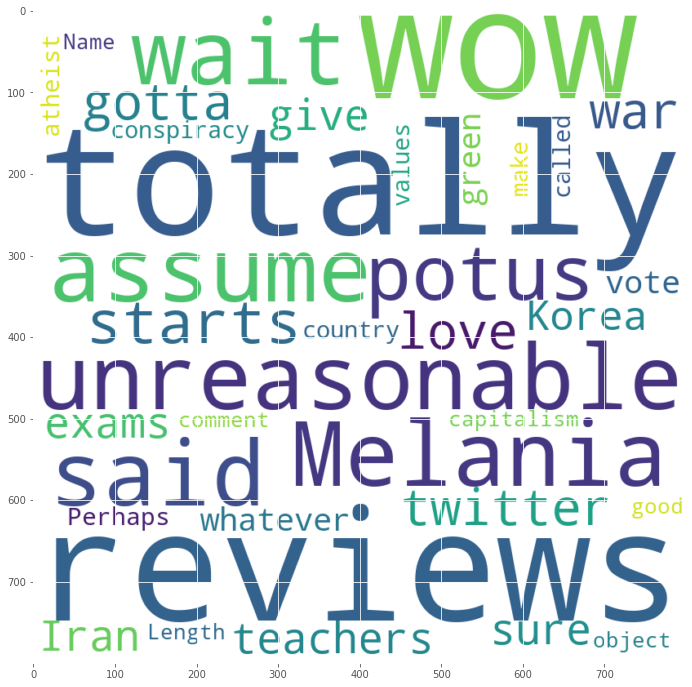

In [ ]:
# creating stop words set
stopwords = set(STOPWORDS)
# adding non-sense words to the stopwords set
stopwords.update({'NH', 'NC', 'ni', 'ho', 'p42dc', 'dtype', 'mone', 'slavs', 'got', 'techn'})
# initializing WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10)
wordcloud.generate(str(df.loc[df['label'] == 1, 'comment']))
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

### 4- Pre-processing
Now, Let's apply pre-processing operations on our text data.<br>
One of the most common things we can do is to remove `contractions`.<br>


In [ ]:
contraction_dict = {"ain't": "is not", "cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have",
                "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

contraction_dict = {k.lower(): v.lower() for k, v in contraction_dict.items()}
# len(contraction_dict)

Furthermore, we'll continue on the pre-processing steps using more common approaches.

In [ ]:
def preprocessing_text(s):
    # making the string lower case and removing white spaces
    s = str(s).lower().strip()
    
    # removing contractions 
    s = " ".join([contraction_dict[word] if word in contraction_dict.keys() else word for word in s.split()])
    
    # removing \n
    s = re.sub('\n', '', s)
    
    # adding spaces before & after punctuations for separating the words. For example, "What?" to "what", "?".
    s = re.sub(r"([?!,+=—&%\'\";:¿।।।|\(\){}\[\]//])", r" \1 ", s)
    
    # removing more than 2 consecutive spaces with 1 space.
    s = re.sub('[ ]{2,}', ' ', s).strip()
    
    return s

In [ ]:
# apply preprocessing_text function
df['comment'] = df['comment'].apply(preprocessing_text)
df.head(n=3)

,label,comment
0,0,nc and nh.
1,0,you do know west teams play against west teams...
2,0,"they were underdogs earlier today , but since ..."


### 5- Tokenization

In [ ]:
# defining the total number of words of our dictionary 
TOTAL_WORDS = 40000

# maximum number of words a sentence can have
MAX_LEN = 50

# width of 1D embedding vector
EMBEDDING_SIZE = 300

In [ ]:
# %%time
tokenizer = Tokenizer(num_words=TOTAL_WORDS)
tokenizer.fit_on_texts(list(df['comment']))

train_df = tokenizer.texts_to_sequences(df['comment'])
train_df = pad_sequences(train_df, maxlen = MAX_LEN)
target = df['label']

### 6- Embedding

In [ ]:
%%time
# Using the 2 million word vectors trained on Common Crawl
EMBEDDING_FILE = '/content/drive/MyDrive/crawl-300d-2M.vec'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(EMBEDDING_FILE, encoding="utf8")))

word_index = tokenizer.word_index
nb_words = min(TOTAL_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_SIZE))


CPU times: user 2min 33s, sys: 7.61 s, total: 2min 41s
Wall time: 2min 51s


In [ ]:
for word, i in tqdm(word_index.items()):
    if i >= TOTAL_WORDS: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(40000, 300)

### 7- Building the model

In [ ]:
input_layer = Input(shape=(MAX_LEN,))

embedding_layer = Embedding(TOTAL_WORDS, EMBEDDING_SIZE, weights = [embedding_matrix])(input_layer)

LSTM_layer = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
maxpool_layer = GlobalMaxPool1D()(LSTM_layer)

dense_layer_1 = Dense(64, activation="relu")(maxpool_layer)
dropout_1 = Dropout(0.5)(dense_layer_1)

dense_layer_2 = Dense(32, activation="relu")(dropout_1)
dropout_2 = Dropout(0.5)(dense_layer_2)

output_layer = Dense(1, activation="sigmoid")(dropout_2)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           12000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           439296    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080  

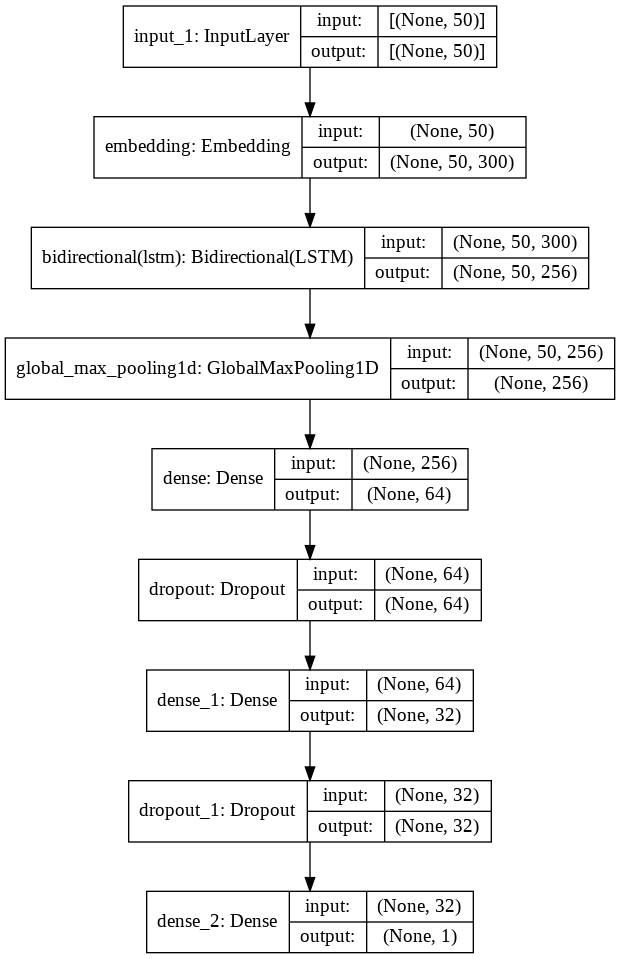

In [ ]:
plot_model(model, show_shapes=True)

### 8- Training the model

In [ ]:
BATCH_SIZE = 512
EPOCHS = 2

history = model.fit(
    train_df, target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    # We are using randomly selected 20% sentences as validation data.
    validation_split=0.2
)

Epoch 1/2
1580/1580 [==============================] - 3039s 2s/step - loss: 0.5932 - accuracy: 0.6827 - val_loss: 0.5280 - val_accuracy: 0.7331
Epoch 2/2
1580/1580 [==============================] - 2985s 2s/step - loss: 0.5215 - accuracy: 0.7448 - val_loss: 0.5184 - val_accuracy: 0.7400


### 9- Result of the model 

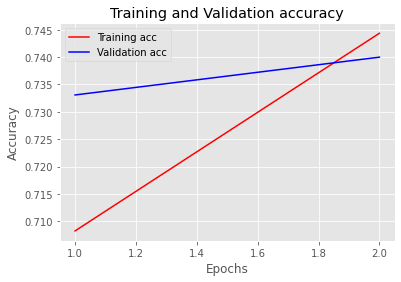

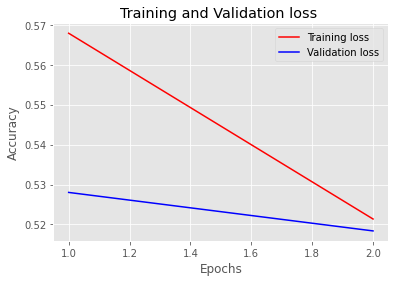

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### 10- Testing the model

In [ ]:
sentence = "Hello Dear Friends!"
sentence = preprocessing_text(sentence)
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen = MAX_LEN)
sentence

hello dear friends !


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 2478, 2793,  449]], dtype=int32)

In [ ]:
prediction = model.predict(sentence)
prediction[0][0]

0.15101856

In [ ]:
print("This sentence is sarcasm with a probability of %.3f percent"%(prediction[0][0]*100))

This sentence is sarcasm with a probability of 15.102 percent


In [ ]:
sentence = "Isn't it great that, your friend died in a car accident harshly?"
sentence = preprocessing_text(sentence)
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen = MAX_LEN)
sentence

is not it great that , your friend died in a car accident harshly ?


array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     2,     7,     8,   121,    10,    39,   466,   885,
           12,     3,   357,  2676, 24476]], dtype=int32)

In [ ]:
prediction = model.predict(sentence)
prediction[0][0]

0.6437669

In [ ]:
print("This sentence is sarcasm with a probability of %.3f percent"%(prediction[0][0]*100))

This sentence is sarcasm with a probability of 64.377 percent
